# Predict Readmission with Machine Learning

Authors:  
Alan Youssef

This project aims to predict if a patient will be readmitted within 30 days of a previous hospital visit, which impacts both healthcare resources and patient health.



## Load data

Inspect the dataset to understand its structure and check for any immediate issues (missing values, data types, etc.).

In [76]:
import numpy as np  # For numerical calculations
import pandas as pd  # For reading and handling the dataset

# Read the dataset
df = pd.read_csv('diabetic_data.csv')

# Display the first few rows to get an overview
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Data cleaning and preprocessing

### Remove NaN Values

Replacing all occurrences of '?' and 'Unknown/Invalid' with NaN.
Identifying columns where more than 25% of the values are missing.
Dropping those columns to reduce noise and improve data quality.

In [77]:
df_cleaned = df.copy()

# Replace all '?' and 'Unvalid/Invalid' with NaN
df_cleaned.replace('?', np.nan, inplace=True)
df_cleaned.replace('Unknown/Invalid', np.nan, inplace=True)

# Identify columns with more than 25% missing values
missing_percent = df_cleaned.isnull().mean() * 100
threshold = 0.25
high_missing_cols = missing_percent[missing_percent > (threshold * 100)].index.tolist()

# Drop the columns
df_cleaned = df_cleaned.drop(columns=high_missing_cols)

### Remove Irrelevant or dominant value columns

Listing irrelevant columns that don’t contribute to analysis.

Listing medium irrelevant columns that might have some value but are not critical.
Identifying low variance columns with only one unique value, which won’t help models.

Combining all these into cols_to_drop and removing them from the dataset.

In [78]:
# List of irrelevant columns
irrelevant_cols = ['encounter_id', 'patient_nbr']

# List of medium irrelevant columns
medium_irrelevant_cols = ['admission_source_id', 'discharge_disposition_id', 
                        'diag_2', 'diag_3', 'num_procedures']

# Identify columns with only one unique value (low variance)
low_variance_cols = [col for col in df_cleaned.columns if df_cleaned[col].nunique() == 1]

# Combine all columns to drop
cols_to_drop = irrelevant_cols + medium_irrelevant_cols + low_variance_cols

# Drop the identified columns
df_cleaned = df_cleaned.drop(columns=cols_to_drop)

### Imputation

**Handling Missing Values in 'Race' Column**  
1. Method 1: Missing values in the 'race' column are filled with the most common category, which is "Caucasian."

2. Method 2 (Optional): Missing values could be filled randomly based on the distribution of race categories.

3. Method 3: An alternative approach is to remove any rows where the 'race' value is missing.

**General Data Cleaning**  
Any rows with missing values in other columns are removed.
Duplicate rows in the dataset are also removed.

In [ ]:
# 3 ways to handle the 'race' problem
# 1. Fill missing values in 'race' with the most common category (Caucasian)
df_cleaned['race'].fillna('Caucasian', inplace=True)

# 2. Frequency distribution for each category in 'race'
# race_distribution = df['race'].value_counts(normalize=True)
# Fill missing values randomly based on the distribution
# df['race'] = df['race'].apply(lambda x: np.random.choice(race_distribution.index, p=race_distribution.values) if pd.isnull(x) else x)

# 3. Remove rows where 'race' is null
# df = df.dropna(subset=['race'])

# Remove rows with missing values
df_cleaned = df_cleaned.dropna()

# Remove duplicates (if any)
df_cleaned = df_cleaned.drop_duplicates()

### Check

After cleaning, the number of missing values in each column is checked to ensure everything is properly handled.

In [80]:
# Check if there are any duplicates in the dataset
duplicates = df_cleaned.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

# Check if there are any missing values
missing_values = df_cleaned.isnull().sum().sum()
print(f"Number of missing values: {missing_values}")

# Summarize the number of columns that have only one unique value
single_unique_value_cols = df_cleaned.nunique()[df_cleaned.nunique() == 1].index.tolist()
print(f"Columns with only one unique value: {single_unique_value_cols}")
print(f"Number of columns with only one unique value: {len(single_unique_value_cols)}")

Number of duplicates: 0
Number of missing values: 0
Columns with only one unique value: []
Number of columns with only one unique value: 0


### Converting Categorical Data

**Here are 3 ways of trying to convert the drug columns from categorical to numerical**

**Solution 1: Binarize Drug Columns**  
In this approach, the drug columns are converted into binary values to make them easier to analyze. If a drug is not used, its value is set to 0, and if it is used (whether the dosage is steady, increased, or decreased), the value is set to 1. This transformation turns the drug information into a format that is more suitable for modeling and analysis.

In [ ]:
# Solution 1: Binarize medication columns
df_bin = df_cleaned.copy()

# List of all medication columns
medication_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                   'acetohexamide','glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
                   'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
                   'insulin', 'glyburide-metformin', 'glipizide-metformin', 
                   'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

# Convert all medication columns to binary values (0 = not used, 1 = used)
df_bin[medication_cols] = df_bin[medication_cols].replace({'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1})

# Display information about the updated dataset
print("Dataset with binary medication columns:")
print(df_bin.info())

**Solution 2: Remove Drug Columns Dominated by 'No'**  
In this approach, drug columns that mostly contain "No" (meaning the drug is not used) are removed from the dataset. If more than 95% of the values in a column are "No," that column is dropped. This helps reduce unnecessary data and focuses on the columns with more relevant information.

In [ ]:
# Solution 2: Remove medication columns that almost only contain "No"
df_filtered = df_cleaned.copy()

# Identify medication columns where "No" appears in more than 95% of the rows
cols_to_drop = [col for col in medication_cols if (df_filtered[col] == 'No').mean() > 0.95]

# Remove these columns from the dataset
df_filtered.drop(columns=cols_to_drop, inplace=True)

# Display information about the updated dataset
print("Dataset where medications dominated by 'No' have been removed:")
print(df_filtered.info())

# Show which medication columns were removed
print(f"Columns removed: {cols_to_drop}")

**Solution 3: Remove Drug Columns and Create a New Medication Count Column**  
In this solution, all individual drug columns are removed, and a new column is created to count how many medications a patient is using (excluding "No"). This new column, "total_medications," provides a summary of the patient's medication usage in one number, simplifying the data and making it easier to analyze. The old drug columns are then dropped to avoid redundancy.

In [ ]:
# Solution 3: Remove all medication columns and create a new column that counts medications
df_medcount = df_cleaned.copy()

# Create a new column that counts how many medications the patient is using (excluding "No")
df_medcount['total_medications'] = (df_medcount[medication_cols] != 'No').sum(axis=1)

# Remove all individual medication columns
df_medcount.drop(columns=medication_cols, inplace=True)

# Display information about the updated dataset
print("Dataset where a new column 'total_medications' replaces the medication columns:")
print(df_medcount.info())

# Show a summary of the new column
print(df_medcount['total_medications'].describe())
df_medcount.head()

Choose convert method for drug columns

In [84]:
# Here we choose which conversion solution to apply
df_cleaned = df_bin.copy()

**Convert target variable to numerical**  
Reclassify 'readmitted' to a Binary Variable
In this step, the 'readmitted' column is converted into a binary variable where:

0 indicates the patient was readmitted within 30 days.
1 indicates the patient was either readmitted after 30 days or not readmitted at all.
This transformation makes the data more suitable for predictive modeling, as it simplifies the "readmitted" variable into a yes/no format.

In [ ]:
# Re-categorize 'readmitted' into a binary variable, the prediction target is whether the patient is readmitted within 30 days
df_cleaned['readmitted'] = df_cleaned['readmitted'].replace({'<30': 0, '>30': 1, 'NO': 1})

# Check the transformation
print(df_cleaned['readmitted'].value_counts())
df_cleaned.head()

**Convert 'diag_1' to a Numeric Column**  
The main goal of this process is to convert the 'diag_1' column into a numeric format. Here's how it's done:

1. Remove rows with letters: Rows containing non-numeric characters (like letters) are filtered out to ensure that only valid numeric data remains.

2. Extract first three characters: Only the first three characters are kept, assuming they represent relevant diagnostic codes.

3. Convert to numeric: The column is then converted to numeric values, with any non-convertible entries removed.

4. Convert to integers: Finally, the column is cast into integers, ensuring all values are whole numbers suitable for analysis.

This transformation makes the 'diag_1' column ready for numerical analysis or modeling.

In [86]:
# Remove all rows where 'diag_1' contains letters
df_cleaned = df_cleaned[~df_cleaned['diag_1'].str.contains(r'[a-zA-Z]', na=False)]

# Extract the first three characters from 'diag_1'
df_cleaned['diag_1'] = df_cleaned['diag_1'].str[:3]

# Attempt to convert to integers
df_cleaned['diag_1'] = pd.to_numeric(df_cleaned['diag_1'], errors='coerce')

# Remove rows that could not be converted to numeric values (NaN)
df_cleaned = df_cleaned.dropna(subset=['diag_1'])

# Convert the column to integer type
df_cleaned['diag_1'] = df_cleaned['diag_1'].astype(int)

**Categorize 'diag_1' Based on ICD-9 Code Groups**  
In this step, a function is created to categorize each 'diag_1' code into predefined groups based on the ICD-9 code ranges. Each range corresponds to a specific category of medical conditions, such as infections, tumors, mental health disorders, and so on. 

Here's how it works:

1. Assign Group Numbers: The function checks the ICD-9 code and assigns a group number based on the defined ranges.

2. Apply Function: The function is applied to the 'diag_1' column, replacing the original ICD-9 code with the corresponding group number.

3. Result Check: The updated 'diag_1' column is displayed to verify that the categorization worked correctly.

This approach helps group the diagnoses into meaningful categories, making the data easier to analyze and interpret.

In [87]:
# Function to assign group numbers based on ICD-9 code
def categorize_icd9_group(code):
    if 1 <= code <= 139:
        return 1  # Infectious and parasitic diseases
    elif 140 <= code <= 239:
        return 2  # Neoplasms
    elif 240 <= code <= 279:
        return 3  # Endocrine, nutritional, and metabolic diseases
    elif 280 <= code <= 289:
        return 4  # Blood diseases and blood-forming organs
    elif 290 <= code <= 319:
        return 5  # Mental disorders
    elif 320 <= code <= 389:
        return 6  # Diseases of the nervous system
    elif 390 <= code <= 459:
        return 7  # Cardiovascular diseases
    elif 460 <= code <= 519:
        return 8  # Respiratory diseases
    elif 520 <= code <= 579:
        return 9  # Digestive diseases
    elif 580 <= code <= 629:
        return 10  # Genitourinary diseases
    elif 630 <= code <= 679:
        return 11  # Pregnancy, childbirth, and puerperium
    elif 680 <= code <= 709:
        return 12  # Skin and subcutaneous tissue diseases
    elif 710 <= code <= 739:
        return 13  # Musculoskeletal and connective tissue diseases
    elif 740 <= code <= 759:
        return 14  # Congenital malformations, deformities, and chromosomal abnormalities
    elif 760 <= code <= 779:
        return 15  # Perinatal conditions
    elif 780 <= code <= 799:
        return 16  # Symptoms, signs, and abnormal clinical findings
    elif 800 <= code <= 999:
        return 17  # Injuries and poisonings
    else:
        return 18  # For all other codes that do not match any category (could be an invalid value)


# Apply the function to replace 'diag_1' with group affiliation
df_cleaned['diag_1'] = df_cleaned['diag_1'].apply(categorize_icd9_group)

**Apply One-Hot Encoding to 'diag_1'**  
In this step, One-Hot Encoding is applied to the 'diag_1' column to create binary columns for each possible diagnosis group:

1. pd.get_dummies: This function creates a new binary column for each unique value in 'diag_1'. For example, if 'diag_1' has group numbers 1, 2, and 3, three new columns (group_1, group_2, and group_3) will be created, with values of 1 or 0 indicating whether the patient belongs to that group.

2. Convert Boolean to Integer: Since One-Hot Encoding creates Boolean values (True/False), they are then converted to integers (1/0) for consistency and easier analysis.

3. Result Check: The resulting dataset is displayed to verify the successful creation of the new columns with binary values for each diagnostic group.

This approach transforms the 'diag_1' column into multiple binary columns, making it ready for modeling or further analysis.

In [ ]:
# Use pd.get_dummies to create One-Hot Encoding for 'diag_1'
df_cleaned_encoded = pd.get_dummies(df_cleaned, columns=['diag_1'], prefix='group')

# Convert boolean columns to integers
df_cleaned_encoded[df_cleaned_encoded.select_dtypes(include='bool').columns] = df_cleaned_encoded.select_dtypes(include='bool').astype(int)

# Display the result
print(df_cleaned_encoded.head())

**Identify Categorical Columns in the Dataset**  
In this step, the script identifies and analyzes the categorical columns in the df_cleaned_encoded dataset:

1. Identify Categorical Columns: Using select_dtypes, it filters out the columns that are of type 'object' or 'category', which are typically used for categorical data.

2. Display Unique Values: For each categorical column, the unique values are displayed along with the total count of unique values. This helps to understand the variety of data in each categorical column.

3. Preview Unique Values: Only the first 20 unique values are shown for each column, preventing the output from being too long if there are many unique values.

This step is useful for checking the diversity of data in categorical columns and identifying any potential issues (like unexpected or incorrect values).

In [89]:
# Identify categorical columns in df_cleaned_encoded
categorical_cols = df_cleaned_encoded.select_dtypes(include=['object', 'category']).columns

# Display unique values for each categorical column
for col in categorical_cols:
    unique_values = df_cleaned_encoded[col].unique()
    print(f"Column: {col}")
    print(f"Number of unique values: {len(unique_values)}")
    print(f"Unique values: {unique_values[:20]}")  # Show max 20 values
    print("-" * 50)


Column: race
Number of unique values: 5
Unique values: ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
--------------------------------------------------
Column: gender
Number of unique values: 2
Unique values: ['Female' 'Male']
--------------------------------------------------
Column: age
Number of unique values: 10
Unique values: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
--------------------------------------------------
Column: change
Number of unique values: 2
Unique values: ['No' 'Ch']
--------------------------------------------------
Column: diabetesMed
Number of unique values: 2
Unique values: ['No' 'Yes']
--------------------------------------------------


**Label Encoding for gender, change, and diabetesMed (Binary Values)**  
In this step, Label Encoding is applied to three categorical columns (gender, change, and diabetesMed) by converting them into binary values:

- gender: "Female" is mapped to 0, and "Male" is mapped to 1.
- change: "No" is mapped to 0, and "Ch" (change) is mapped to 1.
- diabetesMed: "No" is mapped to 0, and "Yes" is mapped to 1.

Label Encoding is a straightforward method to convert categorical text data into numerical values, making it easier for machine learning models to process. This approach works well when the categories are binary (i.e., two distinct categories).

In [90]:
# 1. For `gender`, `change`, and `diabetesMed`: Label Encoding (binary values)
df_cleaned_encoded['gender'] = df_cleaned_encoded['gender'].map({'Female': 0, 'Male': 1})
df_cleaned_encoded['change'] = df_cleaned_encoded['change'].map({'No': 0, 'Ch': 1})
df_cleaned_encoded['diabetesMed'] = df_cleaned_encoded['diabetesMed'].map({'No': 0, 'Yes': 1})


**One-Hot Encoding for race and Convert True/False to 1/0**  
In this step, One-Hot Encoding is applied to the race column, and the True/False values are converted to 1/0:

1. One-Hot Encoding: The pd.get_dummies() function is used to create a new binary column for each unique value in the race column. This results in a separate column for each possible race category, where each column will have a value of 1 if the patient belongs to that race, or 0 if they do not.

2. Convert True/False to 1/0: After One-Hot Encoding, any boolean (True/False) values are converted to integers, where True becomes 1 and False becomes 0. This ensures that the dataset is numeric and ready for analysis.

This transformation is useful for representing categorical variables in a way that machine learning models can process effectively.

In [ ]:
# 2. For `race`: One-Hot Encoding and convert True/False to 1/0
df_cleaned_encoded = pd.get_dummies(df_cleaned_encoded, columns=['race'], drop_first=False)

# Replace True/False with 1/0 for `race` columns
df_cleaned_encoded = df_cleaned_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))

**Group Age Intervals into Numerical Values**  
In this step, the age column is grouped into predefined age intervals and mapped to numerical values:

1. Age Mapping: A dictionary is created to assign each age range (e.g., '[0-10)', '[10-20)', etc.) a specific numeric value.

2. Apply Mapping: The map() function is used to replace the age intervals in the age column with their corresponding numeric values. This simplifies the age data, making it easier to work with in analysis or modeling.

This transformation effectively converts categorical age ranges into numeric values that can be more easily processed by machine learning algorithms.

In [92]:
# 3. For `age`: Group intervals into numerical values
age_mapping = {
    '[0-10)': 1,
    '[10-20)': 2,
    '[20-30)': 3,
    '[30-40)': 4,
    '[40-50)': 5,
    '[50-60)': 6,
    '[60-70)': 7,
    '[70-80)': 8,
    '[80-90)': 9,
    '[90-100)': 10
}

df_cleaned_encoded['age'] = df_cleaned_encoded['age'].map(age_mapping)

### Final Check before normalizattion

**Here's what is being checked:**

- Dataset shape: The number of rows and columns after cleaning to confirm no unintended data loss.

- Null values: Checking for any remaining missing values to ensure completeness.

- Unique values per column: Verifying that categorical columns have the expected number of unique values after transformations.

- Statistical summary: Reviewing summary statistics for numeric columns to check for correct distributions.

- Data types: Ensuring each column has the appropriate data type, like numeric for age and encoded values.

- Category frequencies: Inspecting the frequency distribution in categorical columns to confirm correct encoding and transformations.

These checks validate that the dataset is ready for further analysis or modeling.









In [93]:
# Check the number of rows and columns after cleaning
print(f"Number of rows and columns after cleaning: {df_cleaned_encoded.shape}")

# Check for null values per column again
print(f"Null values per column after cleaning:\n{df_cleaned_encoded.isnull().sum()}")

# Check the number of unique values per column
unique_counts_cleaned = df_cleaned_encoded.nunique()
print(f"Number of unique values per column after cleaning:\n{unique_counts_cleaned}")

# Display a statistical summary for numerical columns
print(f"Statistical summary:\n{df_cleaned_encoded.describe()}")

# Display a summary of the dataset's data types
print(f"Data types for each column:\n{df_cleaned_encoded.dtypes}")

# Count occurrences of each category in important columns
categorical_cols = df_cleaned_encoded.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nOccurrences of each category in {col}:\n{df_cleaned_encoded[col].value_counts()}")

Number of rows and columns after cleaning: (100094, 55)
Null values per column after cleaning:
gender                      0
age                         0
admission_type_id           0
time_in_hospital            0
num_lab_procedures          0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
insulin                     0
glyburide-metformin         0
glipizide-metformin         0
glimepiride-pioglitazone    0
metformin-rosiglitazone     0
metfo

### Normalization

- Selecting numerical columns: Chosen columns like num_lab_procedures and num_medications for scaling.

- Creating a scaler: Using StandardScaler (or MinMaxScaler) to normalize the data.

- Applying the scaler: Transforming the selected columns using the scaler.

- Checking the result: Displaying the first few rows to confirm the normalization was applied correctly.

In [94]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select the columns that need normalization
numerical_cols = ['num_lab_procedures', 'num_medications', 'number_outpatient', 
                  'number_emergency', 'number_inpatient', 'time_in_hospital', 
                  'number_diagnoses']  # Add or remove columns as needed

# Create an instance of StandardScaler or MinMaxScaler
scaler = StandardScaler()  # For Standardization
# scaler = MinMaxScaler()  # For Min-Max normalization

# Apply the scaler to the numerical columns
df_cleaned_encoded[numerical_cols] = scaler.fit_transform(df_cleaned_encoded[numerical_cols])

# Check the first few rows to ensure that normalization has been applied
print(df_cleaned_encoded[numerical_cols].head())


   num_lab_procedures  num_medications  number_outpatient  number_emergency  \
0           -0.113298        -1.841861          -0.291073         -0.213284   
1            0.800962         0.241053          -0.291073         -0.213284   
2           -1.637063        -0.371568           1.281095         -0.213284   
3            0.039079        -0.003995          -0.291073         -0.213284   
4            0.394624        -0.984190          -0.291073         -0.213284   

   number_inpatient  time_in_hospital  number_diagnoses  
0         -0.497485         -1.135979         -3.313080  
1         -0.497485         -0.456752          0.816432  
2          0.296685         -0.796365         -0.732135  
3         -0.497485         -0.796365         -0.215946  
4         -0.497485         -1.135979         -1.248324  


## Data Evaluation

### Exploratory Data Analysis (EDA)

- Understanding distributions of numerical and categorical features.

- Visualizing Categorical Features

- Evaluating distributions of key categorical variables.

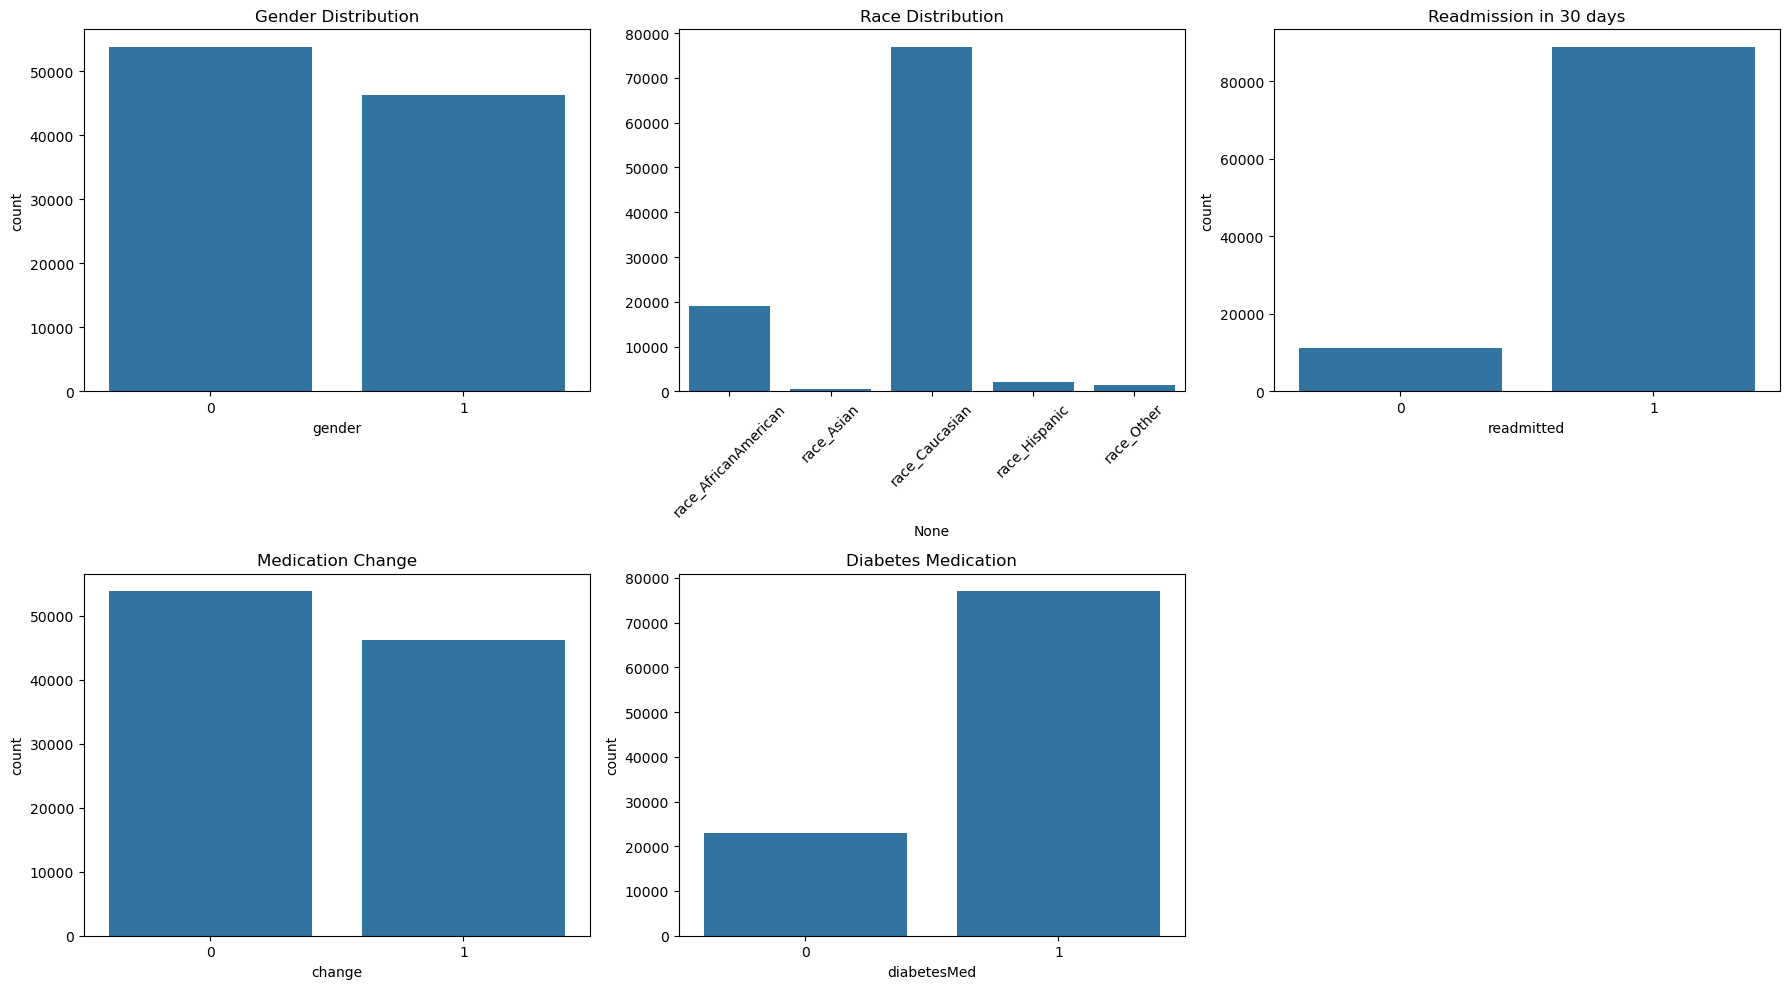

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 10))

# Gender
plt.subplot(2, 3, 1)
sns.countplot(x='gender', data=df_cleaned_encoded)
plt.title("Gender Distribution")

# Race
plt.subplot(2, 3, 2)
race_cols = ['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other']
race_counts = df_cleaned_encoded[race_cols].sum()
sns.barplot(x=race_counts.index, y=race_counts.values)
plt.xticks(rotation=45)
plt.title("Race Distribution")

# Readmission
plt.subplot(2, 3, 3)
sns.countplot(x='readmitted', data=df_cleaned_encoded)
plt.title("Readmission in 30 days")

# Medication Change
plt.subplot(2, 3, 4)
sns.countplot(x='change', data=df_cleaned_encoded)
plt.title("Medication Change")

# Diabetes Medication
plt.subplot(2, 3, 5)
sns.countplot(x='diabetesMed', data=df_cleaned_encoded)
plt.title("Diabetes Medication")

plt.tight_layout()
plt.show()


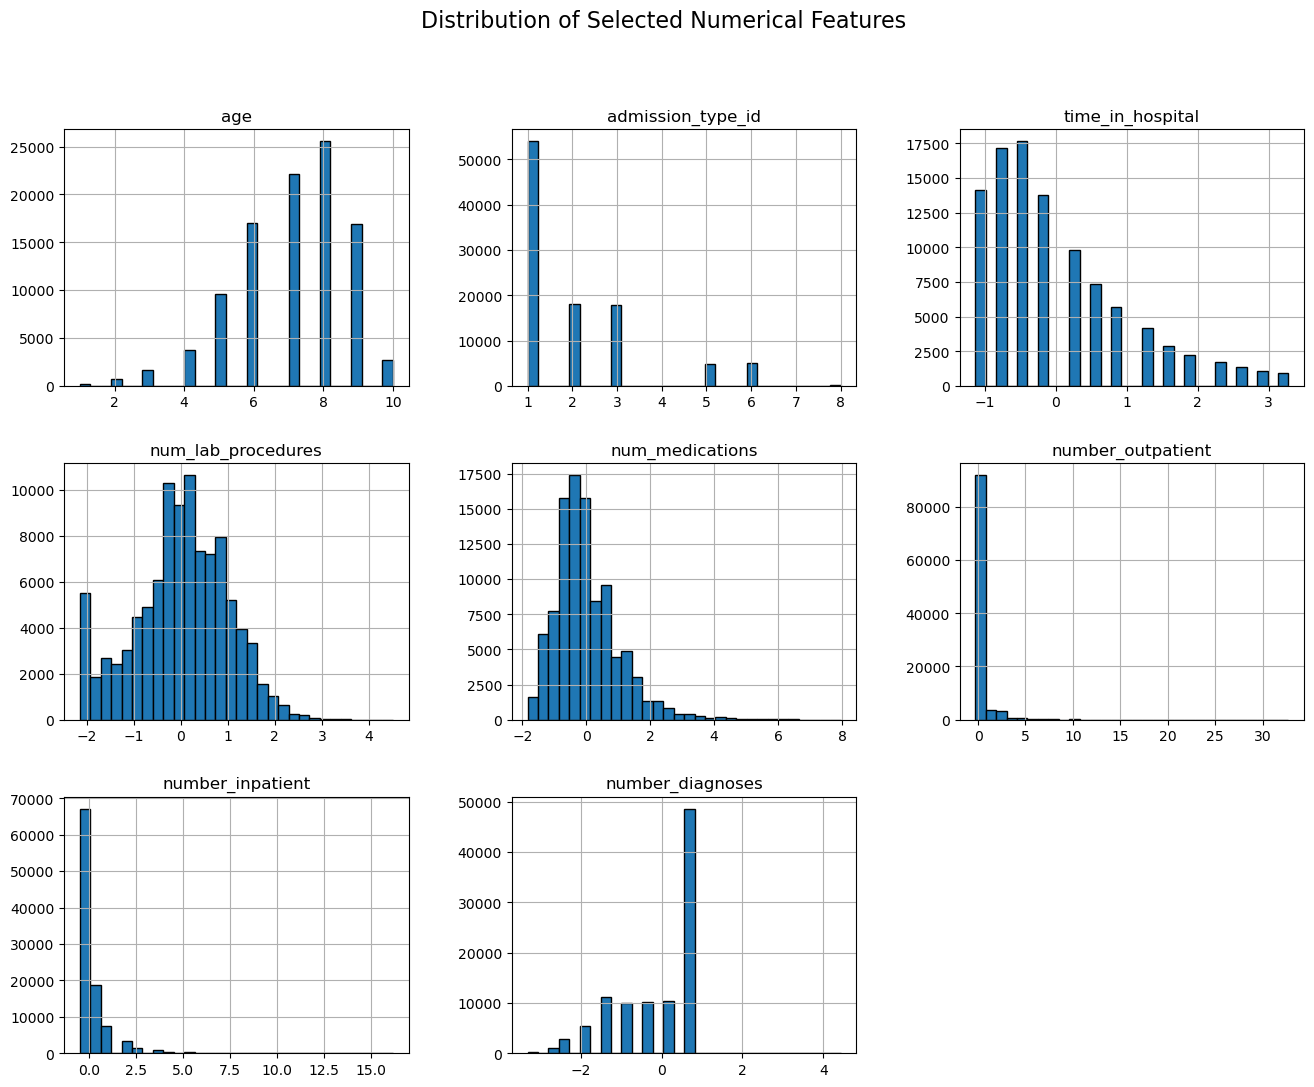

In [96]:
selected_columns = ['age', 'admission_type_id', 'time_in_hospital', 'num_lab_procedures', 
                    'num_medications', 'number_outpatient', 'number_inpatient', 'number_diagnoses']

df_cleaned_encoded[selected_columns].hist(figsize=(16, 12), bins=30, edgecolor='black')
plt.suptitle("Distribution of Selected Numerical Features", fontsize=16)
plt.show()


### Check for Class Imbalance

Checking if the target variable is imbalanced, which might require resampling.

Class distribution of 'readmitted':
readmitted
1    89008
0    11086
Name: count, dtype: int64


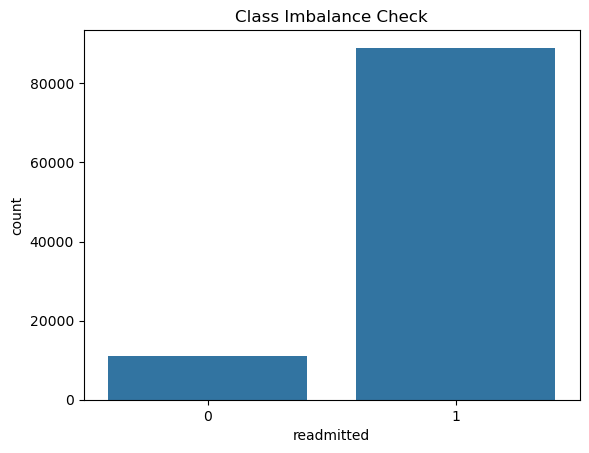

In [97]:
print("Class distribution of 'readmitted':")
print(df_cleaned_encoded['readmitted'].value_counts())

sns.countplot(x='readmitted', data=df_cleaned_encoded)
plt.title("Class Imbalance Check")
plt.show()

### Correlation Matrix

Evaluating correlations between numerical features using a heatmap.

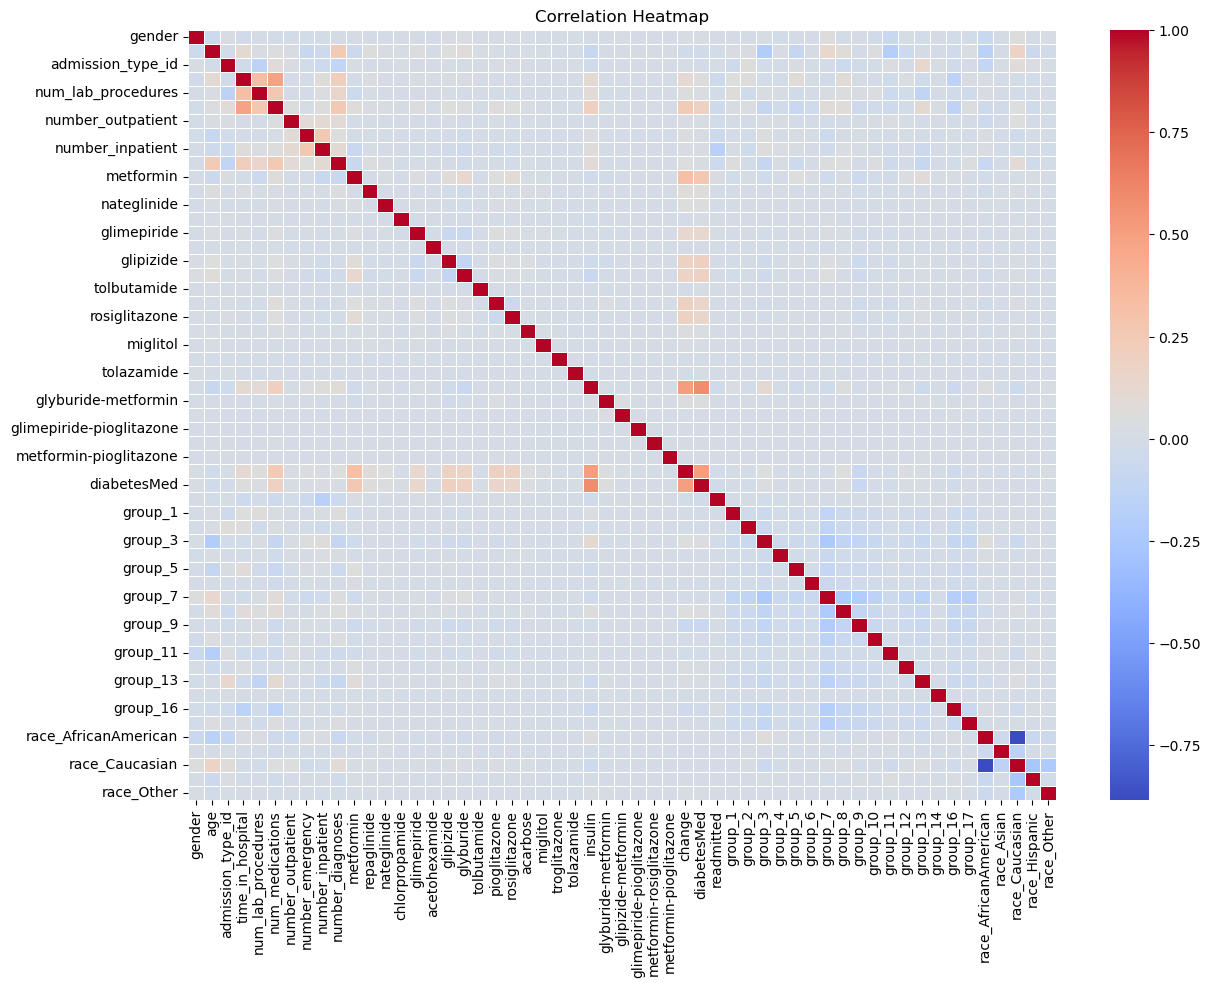

In [98]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_cleaned_encoded.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### Outlier Detection

Detecting outliers using boxplots.

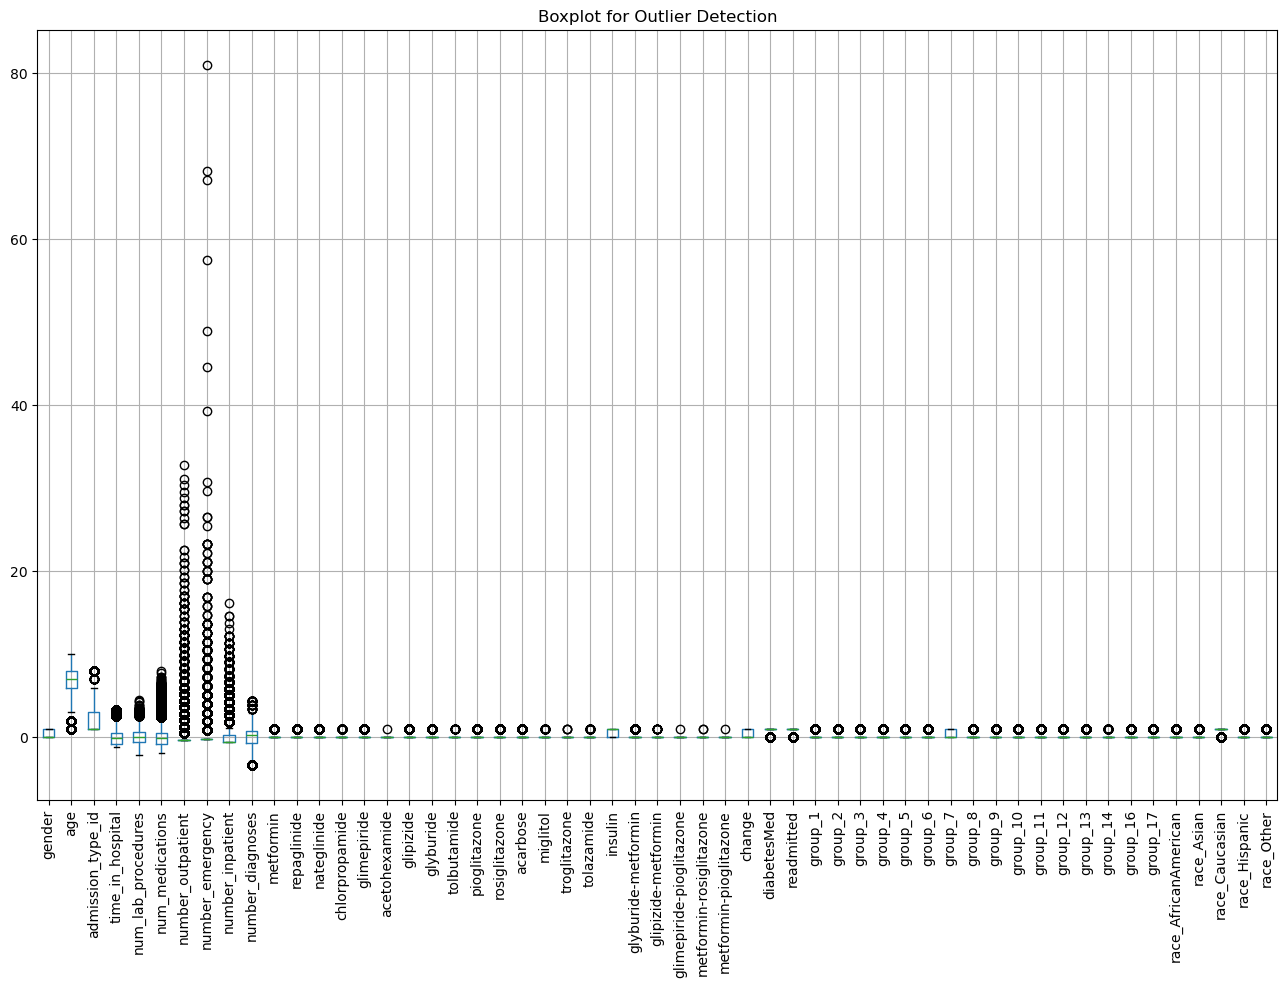

In [99]:
plt.figure(figsize=(16, 10))
df_cleaned_encoded.boxplot(rot=90)
plt.title("Boxplot for Outlier Detection")
plt.show()


### Feature Importance

Assessing feature importance using a trained Random Forest model.

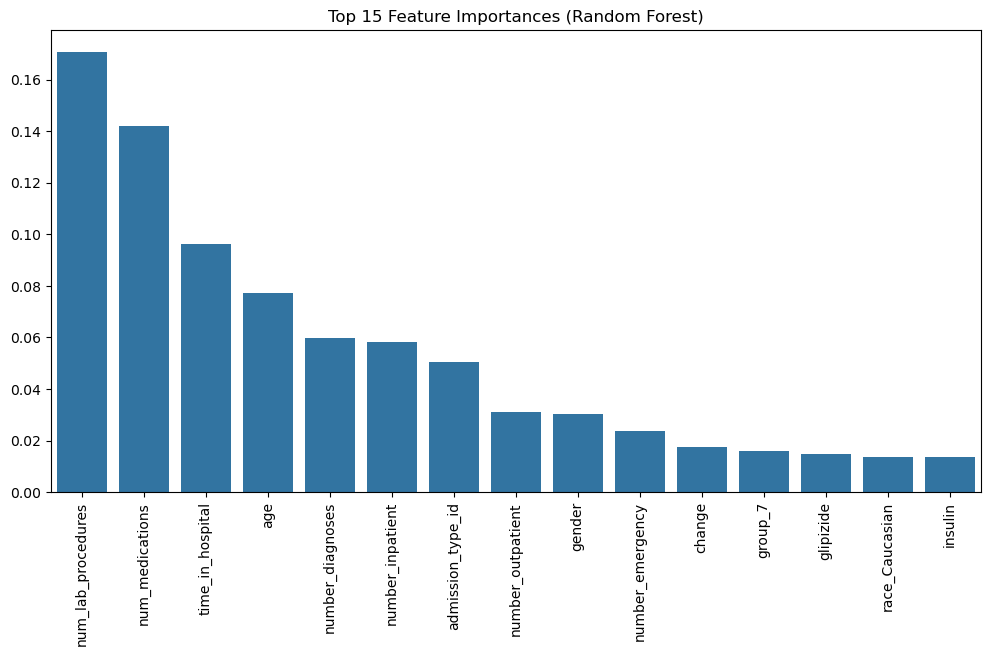

In [100]:
import numpy as np

# Fit a RandomForest model if not already trained
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Extract feature importance
feature_importances = rf_clf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=[X_train.columns[i] for i in sorted_indices[:15]], y=feature_importances[sorted_indices[:15]])
plt.xticks(rotation=90)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


### Pairplot for Relationships

Visualizing relationships between key numerical features.

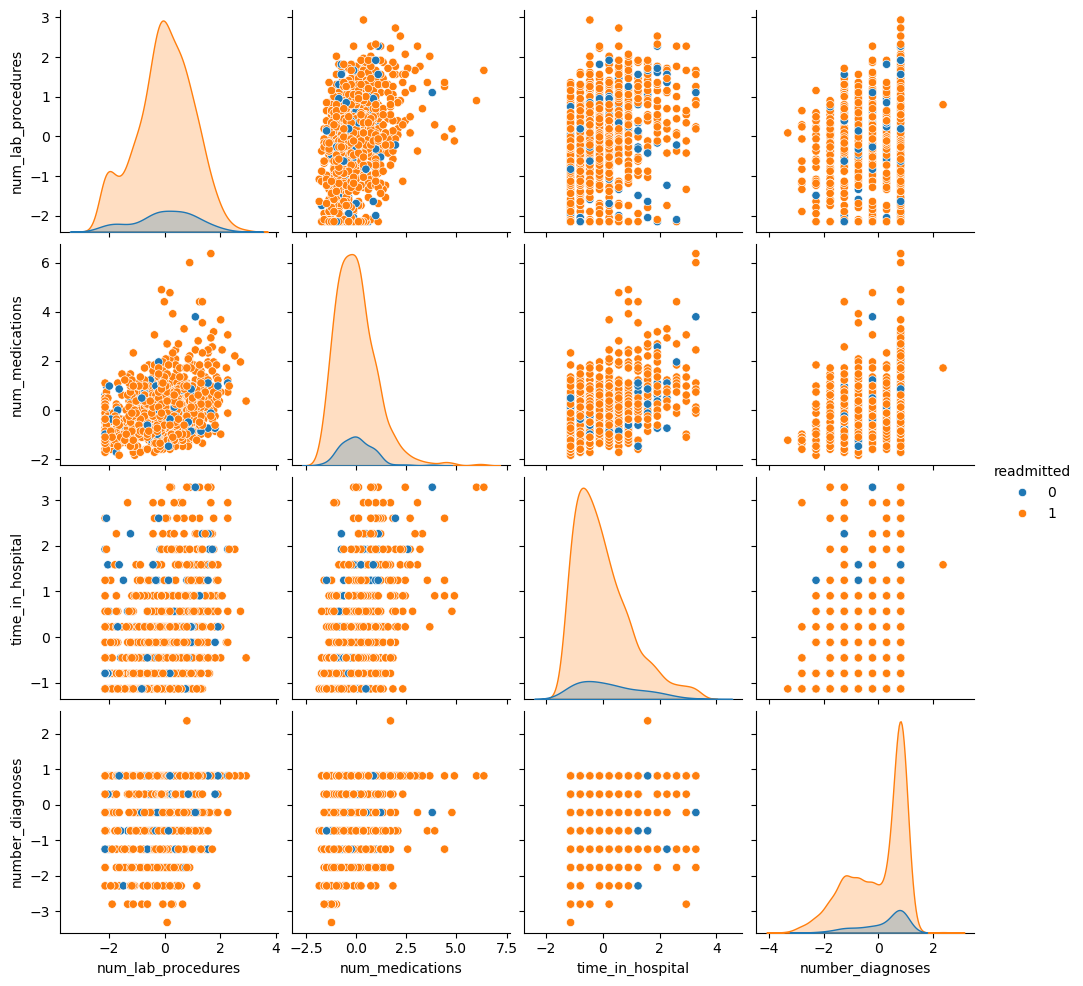

In [101]:
sampled_df = df_cleaned_encoded.sample(1000)  # Reduce size for better visualization
sns.pairplot(sampled_df, vars=['num_lab_procedures', 'num_medications', 'time_in_hospital', 'number_diagnoses'], hue='readmitted')
plt.show()

## Data Splitting

### Split the data with test_train_split

Splits the data into training and testing sets for model building and evaluation. Separates the features from the target variable and ensures the target distribution is preserved in both sets.

- Selects features and target.

- Splits the data into 80% training and 20% testing sets.

- Stratifies the split to maintain target distribution.

- Checks dimensions of the training and testing datasets for both features and target variables.

In [102]:
from sklearn.model_selection import train_test_split

# 'readmitted' is the target variable you want to predict

X = df_cleaned_encoded.drop(columns=['readmitted'])  # Features (all columns except the target variable)
y = df_cleaned_encoded['readmitted']  # Target variable

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the dimensions of training and test data
print(f"Training data (features): {X_train.shape}")
print(f"Test data (features): {X_test.shape}")
print(f"Training data (target): {y_train.shape}")
print(f"Test data (target): {y_test.shape}")


Training data (features): (80075, 54)
Test data (features): (20019, 54)
Training data (target): (80075,)
Test data (target): (20019,)


## Model Training & Evaluation

### Logistic Regression

Trains a logistic regression model and evaluates its performance using a classification report. The model is trained on the training data and makes predictions on the test data, with its performance being assessed based on various classification metrics.

- Creates an instance of the logistic regression model.

- Trains the model using the training data.

- Makes predictions on the test data.

- Evaluates the model using a classification report, showing metrics like precision, recall, and F1-score.

In [103]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create an instance of the model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.55      0.02      0.03      2217
           1       0.89      1.00      0.94     17802

    accuracy                           0.89     20019
   macro avg       0.72      0.51      0.49     20019
weighted avg       0.85      0.89      0.84     20019



### Random Forest Classifier

Trains a random forest classifier model and evaluates its performance using a classification report. The model is trained on the training data, makes predictions on the test data, and its performance is assessed based on key classification metrics.

- Creates an instance of the random forest classifier model.

- Trains the model using the training data.

- Makes predictions on the test data.

- Evaluates the model using a classification report, showing metrics like precision, recall, and F1-score.

In [104]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Create an instance of the model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred_rf_clf = rf_clf.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred_rf_clf))


Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       0.38      0.01      0.02      2217
           1       0.89      1.00      0.94     17802

    accuracy                           0.89     20019
   macro avg       0.63      0.50      0.48     20019
weighted avg       0.83      0.89      0.84     20019



### k-Nearest Neighbors (k-NN)

Trains a k-nearest neighbors (k-NN) classifier and evaluates its performance using accuracy and a detailed classification report. The model is trained on the training data, makes predictions on the test data, and the performance is evaluated using accuracy and classification metrics.

- Creates an instance of the k-NN model with a specified number of neighbors.

- Trains the model using the training data.

- Makes predictions on the test data.

- Calculates and displays the accuracy score.

- Provides a detailed classification report, including metrics like precision, recall, and F1-score.

In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create an instance of the k-NN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors based on your data

# Train the model on the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred_knn = knn.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy (k-NN): {accuracy_knn:.4f}")

# Display a more detailed report
print("Classification Report (k-NN):")
print(classification_report(y_test, y_pred_knn))

Accuracy (k-NN): 0.8783
Classification Report (k-NN):
              precision    recall  f1-score   support

           0       0.24      0.05      0.08      2217
           1       0.89      0.98      0.93     17802

    accuracy                           0.88     20019
   macro avg       0.57      0.51      0.51     20019
weighted avg       0.82      0.88      0.84     20019



### Support Vector Machine (SVM)

Trains a support vector machine (SVM) classifier and evaluates its performance using a classification report. The model is trained on the training data, makes predictions on the test data, and its performance is assessed using various classification metrics.

- Creates an instance of the SVM model.

- Trains the model using the training data.

- Makes predictions on the test data.

- Evaluates the model using a classification report, showing metrics like precision, recall, and F1-score.

In [106]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Create an instance of the model
svm_clf = SVC()

# Train the model
svm_clf.fit(X_train, y_train)

# Make predictions
y_pred_svm_clf = svm_clf.predict(X_test)

# Evaluate the model
print("Support Vector Machine Performance:")
print(classification_report(y_test, y_pred_svm_clf))


Support Vector Machine Performance:
              precision    recall  f1-score   support

           0       0.60      0.00      0.00      2217
           1       0.89      1.00      0.94     17802

    accuracy                           0.89     20019
   macro avg       0.74      0.50      0.47     20019
weighted avg       0.86      0.89      0.84     20019

